In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


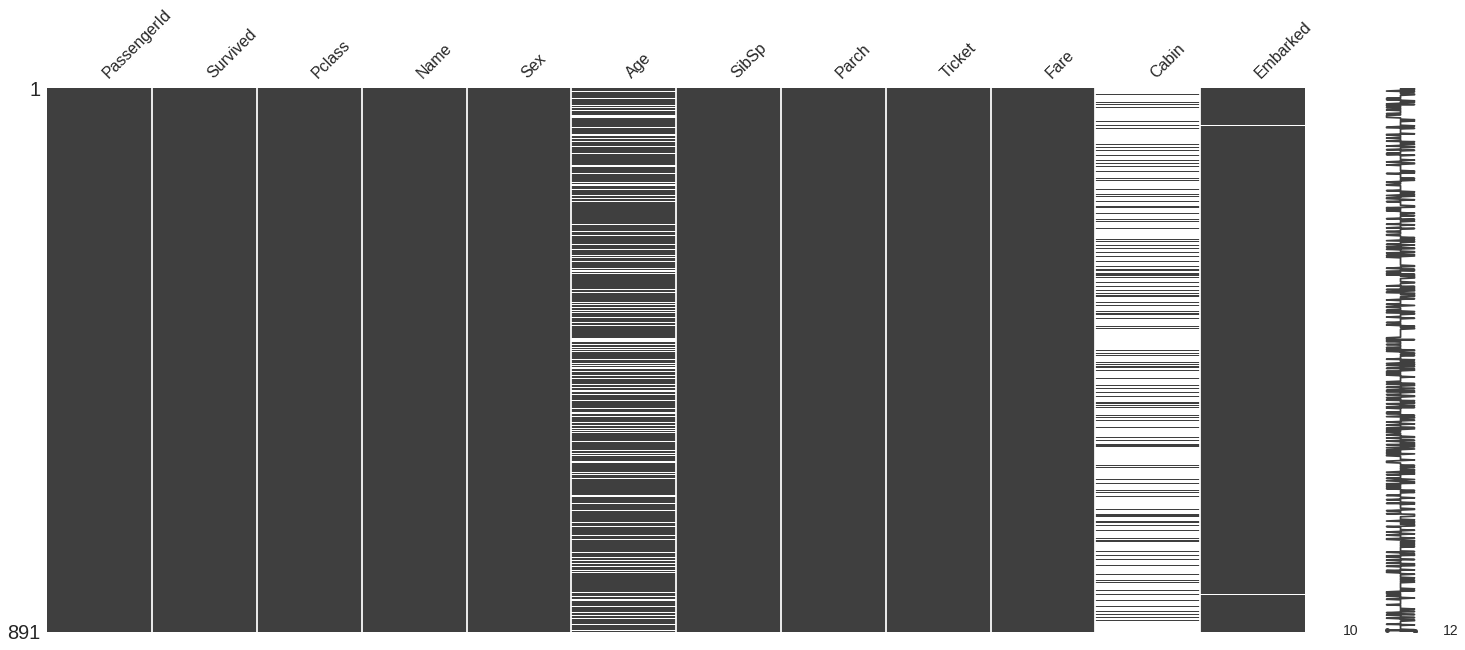

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#####################################################
#Read training data using pandas
data_train=pd.read_csv('/gdrive/My Drive/data/train.csv')

data_train.info() #pandas는 데이터의 분석을 용이하게 하는 기능이 많은데, info()는 그 주요 기능 중 하나이다.
data_train.head()

#####################################################
#Visualize NaN value
import missingno as msno
msno.matrix(data_train)
plt.show()

In [3]:
#####################################################
#Preprocessing - training data
#####################################################
#Initial
data_train["Initial"] = data_train.Name.str.extract('([A-Za-z]+)\.')
data_train["Initial"].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
length=len(data_train)
train = data_train[:length]
train["Survived"] = data_train["Survived"]
#train.groupby("Initial").mean()["Survived"].plot.bar()
#생존이 1 죽음이 0일 때, Initial별로 그 평균 값 계산 


#####################################################
#Has Cabin : Cabin 값이 있는지 없는지
data_train["Has_Cabin"]=pd.isnull(data_train["Cabin"]).astype('int')

#####################################################
#Cabin initial : Cabin 값 중 문자를 추출
train_cabin=train[train["Cabin"].notnull()]
train_cabin["Cabin_Initial"] = train_cabin["Cabin"].apply(lambda x: x[0])
##print(train_cabin["Cabin_Initial"].value_counts())
df_cabin = data_train[data_train["Cabin"].notnull()]
df_cabin["Cabin_Initial"] = df_cabin["Cabin"].apply(lambda x: x[0])
data_train["Cabin_Initial"] = data_train["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else x)
data_train["Cabin_Initial"] = data_train["Cabin_Initial"].map({'A':-1,'B':-0.75,'C':-0.5,'D':-0.25,'E':0.25,'F':0.5,'G':0.75,'T':1})
#data_train["Cabin_Initial"] = data_train["Cabin_Initial"].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8})
data_train["Cabin_Initial"] = data_train["Cabin_Initial"].fillna(0)
data_train["Cabin_Initial"] = data_train["Cabin_Initial"].astype('int')
#print(data_train["Cabin_Initial"].value_counts())


#####################################################
#Familiy Size
data_train["FamilySize"] = data_train["SibSp"] + data_train["Parch"] + 1
#print(data_train["FamilySize"])

#####################################################
#Age : Initial별로 보았을 때, 평균 값을 구하고 Age의 결측치는 이를 반영
#MedianAge=data_train.Age.median() #Age 결측치는 median으로 대체
#data_train.Age=data_train.Age.fillna(value=MedianAge)
#print(data_train.groupby("Initial").mean())
data_train["Age"] = data_train.groupby("Initial").transform(lambda x: x.fillna(x.mean()))["Age"]

#####################################################
#Embarked : 최빈 값으로 결측치를 대체
ModeEmbarked=data_train.Embarked.mode()[0] 
data_train.Embarked=data_train.Embarked.fillna(value=ModeEmbarked)

#####################################################
#Fare : 평균으로 결측치를 대체
MedianFare=data_train.Fare.median()
data_train.Fare=data_train.Fare.fillna(value=MedianFare)

#####################################################
from sklearn.preprocessing import StandardScaler
##수치형 변수들 스케일링 해주기 - Standardization 표준화
scale = StandardScaler().fit(data_train[['Age','Fare']])
data_train[['Age','Fare']]=scale.transform(data_train[['Age','Fare']])
data_train['Pclass']=data_train['Pclass']-2
data_train['SibSp']=(data_train['SibSp']/max(data_train['SibSp']) - 0.5)*2
data_train['Parch']=(data_train['Parch']/max(data_train['Parch']) - 0.5)*2
data_train['FamilySize']=(data_train['FamilySize']/max(data_train['FamilySize']) - 0.5)*2
data_train['Has_Cabin']=(data_train['Has_Cabin']-0.5)*2
#####################################################
#Mapping : Categorical variable
data_train.replace({'male':-1, 'female':1, "Q":-1, "S":0, "C":1},inplace=True)
data_train.replace({"Miss":-1, "Mr":-0.5, "Mrs":0, "Master":0.5, "Other":1},inplace=True)

#####################################################
#Discarding some of the feature
Target=data_train.Survived
features = data_train.drop(['Survived','Name','Ticket','Cabin','PassengerId'],axis=1)
print(features)

#############################W########################
#Split the training and test dataset
from sklearn.model_selection import train_test_split
# training / test set 나누기
X_train, X_val, y_train, y_val = train_test_split(features,Target,test_size = 0.1, random_state=42, shuffle=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


     Pclass  Sex       Age  SibSp     Parch      Fare  Embarked  Initial  \
0         1   -1 -0.587589  -0.75 -1.000000 -0.502445         0     -0.5   
1        -1    1  0.617883  -0.75 -1.000000  0.786845         1      0.0   
2         1    1 -0.286221  -1.00 -1.000000 -0.488854         0     -1.0   
3        -1    1  0.391857  -0.75 -1.000000  0.420730         0      0.0   
4         1   -1  0.391857  -1.00 -1.000000 -0.486337         0     -0.5   
5         1   -1  0.221554  -1.00 -1.000000 -0.478116        -1     -0.5   
6        -1   -1  1.823354  -1.00 -1.000000  0.395814         0     -0.5   
7         1   -1 -2.094427  -0.25 -0.666667 -0.224083         0      0.5   
8         1    1 -0.210879  -1.00 -0.333333 -0.424256         0      0.0   
9         0    1 -1.190324  -0.75 -1.000000 -0.042956         1      0.0   
10        1    1 -1.943744  -0.75 -0.666667 -0.312172         0     -1.0   
11       -1    1  2.124721  -1.00 -1.000000 -0.113846         0     -1.0   
12        1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
data_train.info()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null int64
Age              891 non-null float64
SibSp            891 non-null float64
Parch            891 non-null float64
Ticket           891 non-null object
Fare             891 non-null float64
Cabin            204 non-null object
Embarked         891 non-null int64
Initial          891 non-null float64
Has_Cabin        891 non-null float64
Cabin_Initial    891 non-null int64
FamilySize       891 non-null float64
dtypes: float64(7), int64(6), object(3)
memory usage: 111.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Pclass           891 non-null int64
Sex              891 non-null int64
Age              891 non-null float64
SibSp            891 no

In [5]:

#####################################################
# Define your model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras import regularizers
#####################################################
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

#####################################################
def build_model():
  model=Sequential()
  model.add(Dense(100,input_dim=11,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(50,init='he_normal',activation='relu'))
  model.add(Dense(11,init='he_normal',activation='relu'))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model

#####################################################
#####################################################
def build_model1():
  model=Sequential()
  model.add(Dense(100,input_dim=11,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(50,init='he_normal',activation='relu'))
  model.add(Dense(11,init='he_normal',activation='relu'))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model

#####################################################
def build_model2():
  model=Sequential()
  model.add(Dense(100,input_dim=11,init='he_normal',activation='relu'))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(50,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(20,init='he_normal',activation='relu'))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model

#####################################################
def build_model3():
  model=Sequential()
  model.add(Dense(100,input_dim=11,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(50,init='he_normal',activation='relu'))
  model.add(Dense(20,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model

#####################################################
def build_model4():
  model=Sequential()
  model.add(Dense(100,input_dim=11,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(50,init='he_normal',activation='relu'))
  model.add(Dense(30,init='he_normal',activation='relu'))
  model.add(Dense(11,init='he_normal',activation='relu'))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model

#####################################################
def build_model5():
  model=Sequential()
  model.add(Dense(20,input_dim=11,init='he_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  #model.add(BatchNormalization(momentum=0.9))
  model.add(Dense(20,init='he_normal',activation='relu'))
  model.add(Dense(11,init='he_normal',activation='relu'))
  model.add(Dense(1,init='he_normal',activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 모델의 Optimizer와 Loss 함수 정의
  return model
'''
#####################################################
# Define ensemble
ensemble_size=5
models=[]
hists=[]
for i in range(ensemble_size):
  model=build_model()
  models.append(model)

###########################################################
'''
#####################################################
# Define ensemble
ensemble_size=5
models=[]
hists=[]

model=build_model1()
models.append(model)
model=build_model2()
models.append(model)
model=build_model3()
models.append(model)
model=build_model4()
models.append(model)
model=build_model5()
models.append(model)

###########################################################




# Learning Rate scheduler

from keras.callbacks import LearningRateScheduler
import math

def step_decay(epochs):
    initial_lrate = 0.01
    drop = 0.8
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epochs)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
  
  
#####################################################
# Define optimizer and loss function
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto') #EarlyStopping  
    

#####################################################
'''
for i in range(ensemble_size):
  hist=models[i].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=100, epochs=500, callbacks=callbacks_list)
  hists.append(hist)
'''
#####################################################
hist=models[0].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=60, epochs=50, callbacks=callbacks_list)
hists.append(hist)
hist=models[1].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=60, epochs=70, callbacks=callbacks_list)
hists.append(hist)
hist=models[2].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=60, epochs=150, callbacks=callbacks_list)
hists.append(hist)
hist=models[3].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=60, epochs=40, callbacks=callbacks_list)
hists.append(hist)
hist=models[4].fit(X_train,y_train, validation_data=(X_val, y_val) ,batch_size=60, epochs=100, callbacks=callbacks_list)
hists.append(hist)

#####################################################



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_dim=11, activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, activation="relu", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, activation="relu", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, input_dim=11, activation="relu", kernel_initializer="he_normal")`
/usr

Instructions for updating:
Use tf.cast instead.
Train on 801 samples, validate on 90 samples
Epoch 1/50
801/801 [==============================] - 1s 675us/step - loss: 2.2281 - acc: 0.7228 - val_loss: 1.6641 - val_acc: 0.8333
Epoch 2/50
801/801 [==============================] - 0s 35us/step - loss: 1.4600 - acc: 0.8127 - val_loss: 1.1383 - val_acc: 0.8333
Epoch 3/50
801/801 [==============================] - 0s 34us/step - loss: 1.0032 - acc: 0.8102 - val_loss: 0.8308 - val_acc: 0.8556
Epoch 4/50
801/801 [==============================] - 0s 33us/step - loss: 0.7462 - acc: 0.8265 - val_loss: 0.6570 - val_acc: 0.8556
Epoch 5/50
801/801 [==============================] - 0s 33us/step - loss: 0.5945 - acc: 0.8402 - val_loss: 0.5259 - val_acc: 0.8111
Epoch 6/50
801/801 [==============================] - 0s 34us/step - loss: 0.5288 - acc: 0.8252 - val_loss: 0.4633 - val_acc: 0.8667
Epoch 7/50
801/801 [==============================] - 0s 31us/step - loss: 0.4793 - acc: 0.8252 - val_loss: 

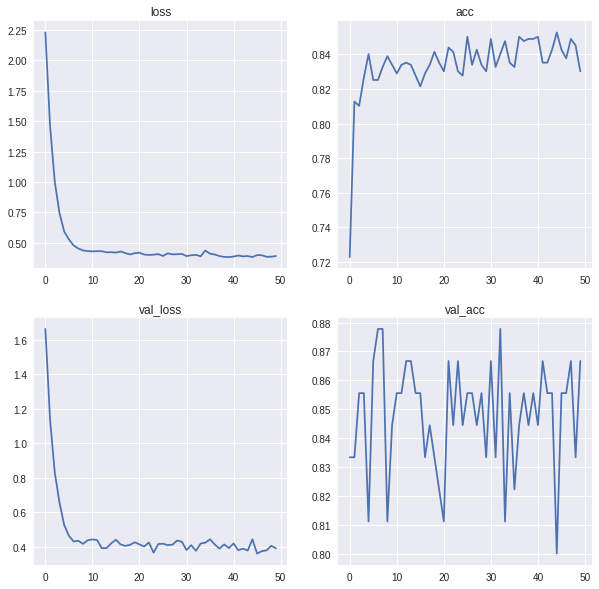

In [6]:
#####################################################
# Visualize the loss function and accuracy
fig, axarr=plt.subplots(2,2,figsize=(10,10))

axarr[0,0].plot(hists[0].history['loss'])
axarr[0,0].set_title('loss')
axarr[0,1].plot(hists[0].history['acc'])
axarr[0,1].set_title('acc')
axarr[1,0].plot(hists[0].history['val_loss'])
axarr[1,0].set_title('val_loss')
axarr[1,1].plot(hists[0].history['val_acc'])
axarr[1,1].set_title('val_acc')

plt.show()

In [7]:
#####################################################
#Preprocessing - test data
#####################################################
#read the test data
data_test=pd.read_csv('/gdrive/My Drive/data/test.csv')
data_test.info()

#####################################################
#Initial
data_test["Initial"] = data_test.Name.str.extract('([A-Za-z]+)\.')
data_test["Initial"].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
length=len(data_test)
test = data_test[:length]


#####################################################
#Has Cabin : Cabin 값이 있는지 없는지
data_test["Has_Cabin"]=pd.isnull(data_test["Cabin"]).astype('int')

#####################################################
#Cabin initial : Cabin 값 중 문자를 추출
test_cabin=test[test["Cabin"].notnull()]
test_cabin["Cabin_Initial"] = test_cabin["Cabin"].apply(lambda x: x[0])
##print(train_cabin["Cabin_Initial"].value_counts())
df_cabin = data_test[data_test["Cabin"].notnull()]
df_cabin["Cabin_Initial"] = df_cabin["Cabin"].apply(lambda x: x[0])
data_test["Cabin_Initial"] = data_test["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else x)
data_test["Cabin_Initial"] = data_test["Cabin_Initial"].map({'A':-1,'B':-0.75,'C':-0.5,'D':-0.25,'E':0.25,'F':0.5,'G':0.75,'T':1})
#data_test["Cabin_Initial"] = data_test["Cabin_Initial"].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8})
data_test["Cabin_Initial"] = data_test["Cabin_Initial"].fillna(0)
data_test["Cabin_Initial"] = data_test["Cabin_Initial"].astype('int')
#print(data_train["Cabin_Initial"].value_counts())


#####################################################
#Familiy Size
data_test["FamilySize"] = data_test["SibSp"] + data_test["Parch"] + 1
#print(data_train["FamilySize"])


#####################################################
#Age : Initial별로 보았을 때, 평균 값을 구하고 Age의 결측치는 이를 반영
#MedianAge=data_test.Age.median() #Age 결측치는 median으로 대체
#data_test.Age=data_test.Age.fillna(value=MedianAge)
print(data_test.groupby("Initial").mean())
data_test["Age"] = data_test.groupby("Initial").transform(lambda x: x.fillna(x.mean()))["Age"]

#####################################################
#Embarked : 최빈 값으로 결측치를 대체
ModeEmbarked=data_test.Embarked.mode()[0]
data_train.Embarked=data_test.Embarked.fillna(value=ModeEmbarked)

#####################################################
#Fare : 평균으로 결측치를 대체
MedianFare=data_test.Fare.median()
data_test.Fare=data_test.Fare.fillna(value=MedianFare)


#####################################################
from sklearn.preprocessing import StandardScaler
##수치형 변수들 스케일링 해주기 - Standardization 표준화
scale = StandardScaler().fit(data_test[['Age','Fare']])
data_test[['Age','Fare']]=scale.transform(data_test[['Age','Fare']])
data_test['Pclass']=data_test['Pclass']-2
data_test['SibSp']=(data_test['SibSp']/max(data_test['SibSp']) - 0.5)*2
data_test['Parch']=(data_test['Parch']/max(data_test['Parch']) - 0.5)*2
data_test['FamilySize']=(data_test['FamilySize']/max(data_test['FamilySize']) - 0.5)*2
data_test['Has_Cabin']=(data_test['Has_Cabin']-0.5)*2
#####################################################
#Mapping : Categorical variable
data_test.replace({'male':-1, 'female':1, "Q":-1, "S":0, "C":1},inplace=True)
data_test.replace({"Miss":-1, "Mr":-0.5, "Mrs":0, "Master":0.5, "Other":1},inplace=True)

#####################################################
#Discarding some of the feature
id=data_test['PassengerId']
data_test = data_test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
print(data_test)
data_test.info()
id=id.as_matrix(columns=None) #pandas series type에서 ndarray type으로 변환
id=id.reshape(-1,1) #matrix를 column으로 reshape



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


         PassengerId    Pclass        Age     SibSp     Parch       Fare  \
Initial                                                                    
Master   1123.380952  2.714286   7.406471  1.571429  1.380952  38.494043   
Miss     1100.240506  2.443038  21.774844  0.544304  0.392405  39.678535   
Mr       1102.471074  2.309917  32.151351  0.272727  0.177686  26.142687   
Mrs      1090.097222  1.833333  38.903226  0.597222  0.833333  59.974249   
Other    1053.500000  1.500000  42.750000  0.500000  0.250000  73.756250   

         Has_Cabin  Cabin_Initial  FamilySize  
Initial                                        
Master    0.904762       0.000000    3.952381  
Miss      0.860759      -0.025316    1.936709  
Mr        0.818182      -0.016529    1.450413  
Mrs       0.555556      -0.013889    2.430556  
Other     0.500000       0.000000    1.750000  
     Pclass  Sex       Age  SibSp     Parch      Fare  Embarked  Initial  \
0         1   -1  0.329783  -1.00 -1.000000 -0.497413  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
#####################################################
# Trial : Stacking

#VotingClasifier
from sklearn.linear_model import LogisticRegression
from subprocess import check_output
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
'''
clf = VotingClassifier([                        
                        ('lsvc',svm.LinearSVC()),
                        ('knn',neighbors.KNeighborsClassifier()),
                        ('rfor',RandomForestClassifier()),
                        ('lr',LogisticRegression()),
                        ('DC',DecisionTreeClassifier()),
                        ('XGB',XGBClassifier()),
                        ('Ada', AdaBoostClassifier()),
                        ])
'''
clf=[]
#####################################################
clf.append(svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
    multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)
          )
#82%
#####################################################
clf.append(LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
                             )
#83%
#####################################################
clf.append(neighbors.KNeighborsClassifier())
#82%
#####################################################
clf.append(DecisionTreeClassifier())
#84%
#####################################################
clf.append(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0))
#86%
#####################################################
clf.append(XGBClassifier())
#84%
#####################################################
clf.append(AdaBoostClassifier())
#83%
#####################################################
#clf.append(GaussianNB())
#80%
#####################################################


In [9]:
#################################
#Save the result
predicts=[]
for i in range(ensemble_size):
  predict=models[i].predict(data_test)
  predicts.append(predict)

for i in range(len(clf)):
  clf[i].fit(X_train, y_train)
  confidence = clf[i].score(X_val, y_val)
  print('clf:',i+1,' Confidence: ',confidence)
  #print(clf[i].predict(data_test))
  predict=clf[i].predict(data_test)
  predict=predict.reshape(-1,1) #matrix를 column으로 reshape
  predicts.append(predict)

'''
predict=clf.predict(data_test)
predict=predict.reshape(-1,1) #matrix를 column으로 reshape
predict=np.concatenate((id,predict),axis=1)
predict=pd.DataFrame(predict,columns=['PassengerId','Survived'])
predict.to_csv('/gdrive/My Drive/predict.csv',index=False)
'''

ensemble_predict=sum(predicts)/(ensemble_size+len(clf))
print(len(ensemble_predict))


for value in range(0,len(ensemble_predict)):
  if ensemble_predict[value] > 0.5 :
    ensemble_predict[value] = 1
  else :
    ensemble_predict[value] = 0

ensemble_predict=ensemble_predict.astype('int')
predict=np.concatenate((id,ensemble_predict),axis=1)
predict=pd.DataFrame(predict,columns=['PassengerId','Survived'])
print(predict.head())
predict.to_csv('/gdrive/My Drive/predict.csv',index=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


clf: 1  Confidence:  0.8222222222222222
clf: 2  Confidence:  0.8333333333333334
clf: 3  Confidence:  0.8222222222222222
clf: 4  Confidence:  0.8111111111111111
clf: 5  Confidence:  0.8666666666666667
clf: 6  Confidence:  0.8444444444444444
clf: 7  Confidence:  0.8333333333333334
418
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
